# Artifact 5: Discrete Allocation Analysis Part 2

In [1]:
# pip install -U yfinance

In [2]:
# pip install -U PyPortfolioOpt

In [3]:
#imports
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import time
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
from pypfopt.plotting import plot_efficient_frontier

In [4]:
stocks = ["AAPL", "MSFT", "GOOG", "NVDA"]
data = yf.download(stocks, start="2013-01-01", end="2023-01-01")['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [5]:
data.to_csv('stock_prices.csv')

In [6]:
df = pd.read_csv('stock_prices.csv')
df_numeric = df.drop(columns=['Date'])
df_numeric.head()

,AAPL,GOOG,MSFT,NVDA
0,16.747721,18.013729,22.532852,2.935840
1,16.536327,18.024191,22.230993,2.938149
2,16.075716,18.380356,21.814926,3.035086
3,15.981152,18.300158,21.774139,2.947381
4,16.024160,18.264042,21.659925,2.882755


In [7]:
mu = expected_returns.capm_return(df_numeric)
S = risk_models.semicovariance(df_numeric, benchmark=((1.0392**(1/252))-1))

ef = EfficientFrontier(mu, S)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.18186), ('GOOG', 0.20478), ('MSFT', 0.29053), ('NVDA', 0.32283)])


In [8]:
ef.portfolio_performance(verbose=True)

Expected annual return: 31.6%
Annual volatility: 19.8%
Sharpe Ratio: 1.49


(0.31584315234037064, 0.19799179955800275, 1.4942192201940252)

/opt/conda/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


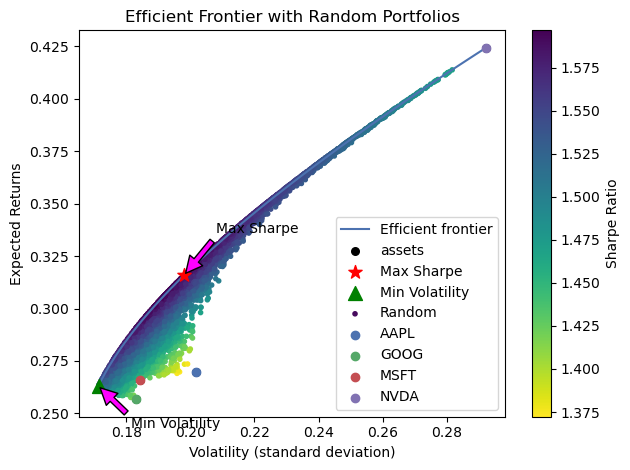

In [9]:
ef_for_plotting = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)  # Change to True to show assets

# Max Sharpe Portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
weights = ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe", zorder=3)

# Min Volatility Portfolio 
ef_min_vol = EfficientFrontier(mu, S)
weights_min_vol = ef_min_vol.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_min_vol, ret_min_vol, marker="^", s=100, c="g", label="Min Volatility", zorder=3)

# Monte Carlo Simulations to generate random portfolios
n_samples = 10000
rand_weights = np.random.dirichlet(alpha=np.ones(ef_for_plotting.n_assets), size=n_samples)
rand_rets = rand_weights.dot(mu)
rand_stds = np.sqrt(np.diag(rand_weights @ S @ rand_weights.T))
sharpes = rand_rets / rand_stds
scatter = ax.scatter(rand_stds, rand_rets, c=sharpes, cmap="viridis_r", marker='.', label="Random")

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Sharpe Ratio")

for ticker in df_numeric.columns:
    ticker_volatility = np.sqrt(S.loc[ticker, ticker])
    ticker_return = mu[ticker]
    ax.scatter(ticker_volatility, ticker_return, marker='o', label=ticker, zorder=2)

ax.annotate('Max Sharpe', xy=(std_tangent, ret_tangent), xytext=(std_tangent+0.01, ret_tangent+0.02),
            arrowprops=dict(facecolor='magenta', shrink=0.05))
ax.annotate('Min Volatility', xy=(std_min_vol, ret_min_vol), xytext=(std_min_vol+0.01, ret_min_vol-0.02),
            arrowprops=dict(facecolor='magenta', shrink=0.05))

ax.legend()
ax.set_title("Efficient Frontier with Random Portfolios")
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Returns')
plt.tight_layout()
plt.show()

In [10]:
latest_prices = get_latest_prices(df_numeric)
print(latest_prices)

AAPL    129.043106
GOOG     88.730003
MSFT    237.273453
NVDA    146.068329
Name: 2517, dtype: float64


## Problem of interest begins over here:

Last artifact we analyzed how a greedy alogorithm for discrete algorithm functions. We conducted comparative and sensitivity analysis for discrete allocation to better understand why the developers of `PyPortfolioOpt` greedy algorithm to be their recommended option for discrete allocation. 

As of yet, the greedy algorithm clearly trumps an Integer Progamming method and a manual weighted method in terms of computation speed and portfolio fund allocation. 

We noticed that there was a clear deviation in weights of stocks (from the global optimization) when greedy algorithm or integer programming optimize fund allocation. What I mean by this is if the portfolio allocation fund has surplus or deficit funds after the weights are assigned dollar amounts (based on their lastest recorded stock price), these algorithms buy or not buy stocks to handle a deficit or a surplus case. In doing so, they altered the pre-assigned weights (by the efficient frontier), and potentially changing the portfolio's expected returns. in this artifact, I'm interested in analyzing this theory.

In the previous artifact, we simulated discretely allocated potfolios for a range of total portfolio values for a chosen discrete optimizer. To achieve our goal, we will back-test the suggested allocations for each simulated portfolio and compare its expected return with the performance of the global porfolio that we found above.

In [11]:
ef.portfolio_performance(verbose=True)
global_return, global_vol, sharpe_ratio = ef.portfolio_performance()

Expected annual return: 31.6%
Annual volatility: 19.8%
Sharpe Ratio: 1.49


So 31.6% is our benchmark expected return calculated using CAPM returns.

We'll first simulate a back-testing algorithm.

Recall the manual weightage method. We simply assign the weights as percentage portions of each stock and find the dollar amounts of them against the total portfolio value. Then we'll divide the dollar amount share of each stock with their latest prices, and round down the quotient to value a conservative mindset.

In [12]:
cleaned_weights

OrderedDict([('AAPL', 0.18186),
             ('GOOG', 0.20478),
             ('MSFT', 0.29053),
             ('NVDA', 0.32283)])

In [13]:
latest_prices

AAPL    129.043106
GOOG     88.730003
MSFT    237.273453
NVDA    146.068329
Name: 2517, dtype: float64

In [14]:
def manual_allocation(cleaned_weights, latest_prices, total_portfolio_value):
    start_time = time.time()

    funds_remaining = total_portfolio_value
    discrete_allocation = {}
    
    for stock, weight in cleaned_weights.items():
        money_allocated = total_portfolio_value * weight
        number_of_shares = np.floor(money_allocated / latest_prices[stock])
        discrete_allocation[stock] = int(number_of_shares)
        funds_remaining -= number_of_shares * latest_prices[stock]
    
    computation_time = time.time() - start_time
    return discrete_allocation, funds_remaining, computation_time

discrete_allocation, funds_re, comp_time = manual_allocation(cleaned_weights, latest_prices, 1000)

We'll use the manual weightage method to devise a back-testing method.

We'll first find the true investment value of the portfolio based on the stocks latest price.

In [15]:
investments = {ticker: shares * latest_prices[ticker] for ticker, shares in discrete_allocation.items()}

In [16]:
total_value = sum(investments.values())

In [17]:
mu

AAPL    0.269623
GOOG    0.256806
MSFT    0.265995
NVDA    0.424189
Name: mkt, dtype: float64

We'll calculate stock weights by finding the ratio of the individual stock's dollar amount to the total investment value. Then, we simply take a dot product between the weights and the global expected return rates of individual stocks.

In [18]:
portfolio_return = sum((investments[ticker] / total_value) * mu[ticker] for ticker in investments)
deviation = portfolio_return - global_return

print(f"Expected Return of the Discrete Allocation: {portfolio_return*100:.2f}%")
print(f"Deviation from Optimized Weights Expected Return: {deviation*100:.2f}%")

Expected Return of the Discrete Allocation: 31.99%
Deviation from Optimized Weights Expected Return: 0.40%


We can observe that the allocated portfolio over here outperforms by 0.4%.

Our back-testing code is fairly simple because we have already done the fair share of work during global optimization. We don't need to worry about calculating expected returns for each stock for any chosen time period, because that's already been calculated under `mu`. We'll simply need to calculate stock weights in our simulations, and that'll help us find the portfolio return.

Let's create a function to backtest our algorithms from before.

In [19]:
def back_testing_function(discrete_allocation):
    investments = {ticker: shares * latest_prices[ticker] for ticker, shares in discrete_allocation.items()}
    total_value = sum(investments.values())

    if total_value == 0:
        portfolio_return = 0
    else:
        portfolio_return = sum((investments[ticker] / total_value) * mu[ticker] for ticker in investments)

    deviation = portfolio_return - global_return
    return portfolio_return * 100, deviation * 100

back_testing_function(discrete_allocation)

(31.989043081846514, 0.4047278478094496)

Defining the interger progamming method and the greedy algorithm from the previous artifact.

In [20]:
def integer_programming_allocation(latest_prices, cleaned_weights, total_portfolio_value):
    start_time = time.time()

    p = latest_prices
    w = np.array([cleaned_weights[ticker] for ticker in latest_prices.keys()])
    x = cp.Variable(len(p), integer=True)
    r = cp.Variable()
    
    objective = cp.Minimize(r + cp.norm(w * total_portfolio_value - cp.multiply(x, p), 1))
    constraints = [r + cp.sum(cp.multiply(x, p)) == total_portfolio_value, x >= 0, r >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    end_time = time.time() 
    computation_time = end_time - start_time
    allocation_output = {ticker: int(num_shares) for ticker, num_shares in zip(latest_prices.index, x.value)}

    return allocation_output, r.value, computation_time

In [21]:
def greedy_allocation_simulation(cleaned_weights, latest_prices, total_portfolio_value):
    start_time = time.time()

    shares = {ticker: (total_portfolio_value * weight) // latest_prices[ticker] for ticker, weight in cleaned_weights.items()}
    funds_remaining = total_portfolio_value - sum(shares[ticker] * latest_prices[ticker] for ticker in shares)

    current_weights = {ticker: shares[ticker] * latest_prices[ticker] / total_portfolio_value for ticker in shares}

    # Adjusted second round of allocation
    while funds_remaining > 0:
        affordable_tickers = {ticker: price for ticker, price in latest_prices.items() if price <= funds_remaining}
        if not affordable_tickers:
            break

        ticker_to_buy = max(affordable_tickers, key=lambda ticker: cleaned_weights[ticker] - current_weights.get(ticker, 0))
        shares[ticker_to_buy] += 1
        funds_remaining -= latest_prices[ticker_to_buy]
        current_weights[ticker_to_buy] = shares[ticker_to_buy] * latest_prices[ticker_to_buy] / total_portfolio_value

    computation_time = time.time() - start_time

    return shares, funds_remaining, computation_time

In [22]:
global_return = global_return * 100

Let's back-test and plot returns for the three values for a range of portfolio values. We'll select the portfolio range to be between $10 to $10000 first.

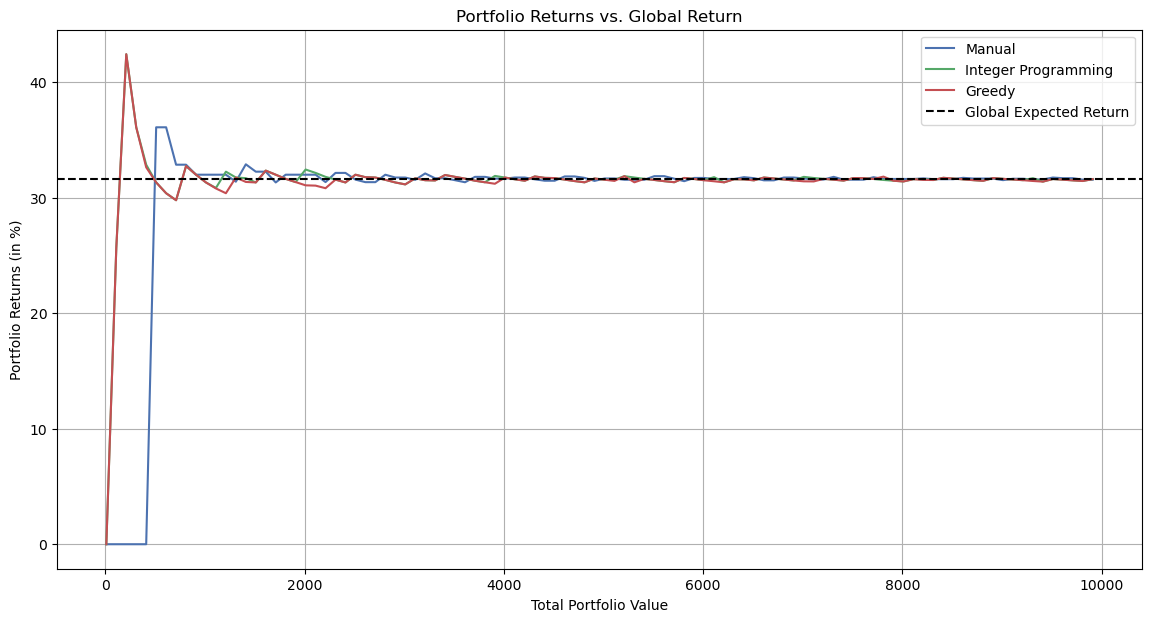

In [23]:
portfolio_values = range(10, 10000, 100)

manual_returns = []
integer_returns = []
greedy_returns = []

for value in portfolio_values:
    manual_allocations, _, _, = manual_allocation(cleaned_weights, latest_prices, value)
    manual_return, _ = back_testing_function(manual_allocations)
    manual_returns.append(manual_return)
    
    integer_allocations, _, _, = integer_programming_allocation(latest_prices, cleaned_weights, value)
    interger_return, _ = back_testing_function(integer_allocations)
    integer_returns.append(interger_return)
    
    greedy_allocations, _, _, = greedy_allocation_simulation(cleaned_weights, latest_prices, value)
    greedy_return, _ = back_testing_function(greedy_allocations)
    greedy_returns.append(greedy_return)

plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, manual_returns, label='Manual')
plt.plot(portfolio_values, integer_returns, label='Integer Programming')
plt.plot(portfolio_values, greedy_returns, label='Greedy')
plt.axhline(y=global_return, color='k', linestyle='--', label='Global Expected Return')
plt.title('Portfolio Returns vs. Global Return')
plt.xlabel('Total Portfolio Value')
plt.ylabel('Portfolio Returns (in %)')
plt.legend()
plt.grid(True)
plt.show()

This is interesting. All the three different algorithms eventually converge to the global expected return that we calculated using `PyPortfolioOpt`. Since they tend to converge, we don't need to simulate backtesting for further portfolio values.

We do observe fluctuations amongst the algorithms initially. But the scale of the graph does not give out too much information. We can zoom in by taking the log scale of portfolio values and further investigating.

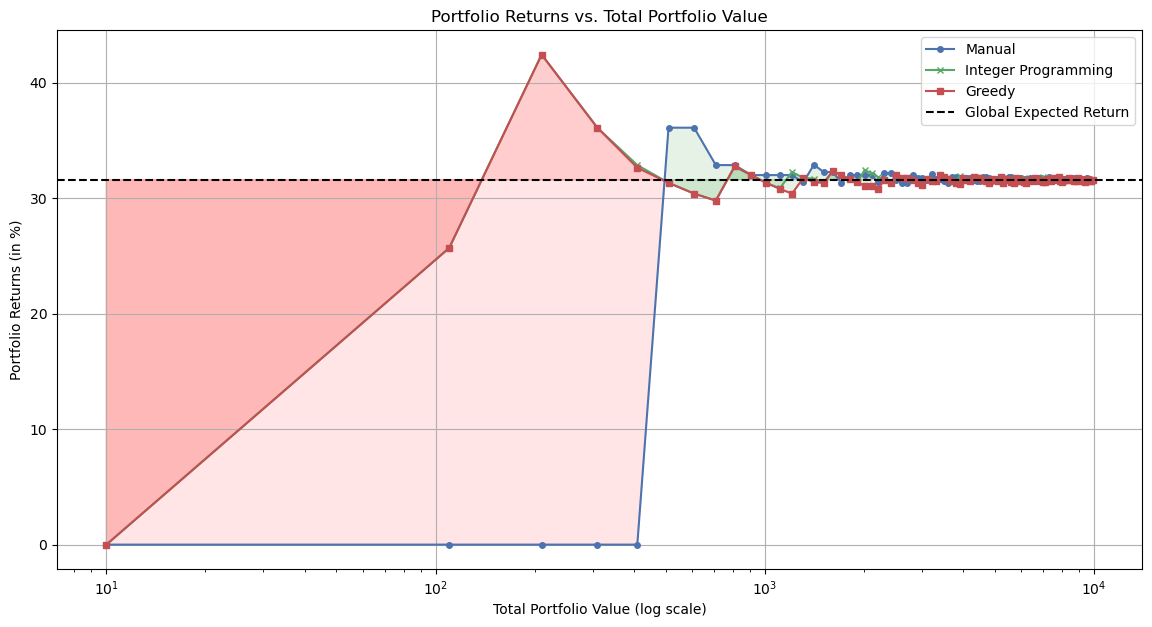

In [25]:
plt.figure(figsize=(14, 7))
portfolio_values_np = np.array(portfolio_values)

# Plotting lines
plt.semilogx(portfolio_values_np, manual_returns, label='Manual', marker='o', markersize=4)
plt.semilogx(portfolio_values_np, integer_returns, label='Integer Programming', marker='x', markersize=4)
plt.semilogx(portfolio_values_np, greedy_returns, label='Greedy', marker='s', markersize=4)

# Shading the area of difference from global_return
plt.fill_between(portfolio_values, manual_returns, global_return, where=(np.array(manual_returns) > global_return), interpolate=True, alpha=0.1, color='green')
plt.fill_between(portfolio_values, manual_returns, global_return, where=(np.array(manual_returns) <= global_return), interpolate=True, alpha=0.1, color='red')

plt.fill_between(portfolio_values, integer_returns, global_return, where=(np.array(manual_returns) > global_return), interpolate=True, alpha=0.1, color='green')
plt.fill_between(portfolio_values, integer_returns, global_return, where=(np.array(manual_returns) <= global_return), interpolate=True, alpha=0.1, color='red')

plt.fill_between(portfolio_values, greedy_returns, global_return, where=(np.array(manual_returns) > global_return), interpolate=True, alpha=0.1, color='green')
plt.fill_between(portfolio_values, greedy_returns, global_return, where=(np.array(manual_returns) <= global_return), interpolate=True, alpha=0.1, color='red')

plt.title('Portfolio Returns vs. Total Portfolio Value')
plt.xlabel('Total Portfolio Value (log scale)')
plt.ylabel('Portfolio Returns (in %)')
plt.axhline(y=global_return, color='k', linestyle='--', label='Global Expected Return')
plt.legend()
plt.grid(True)
plt.show()

**Analysis:**

1. The algorithms, all tend to converge after the 1000 mark. All the three algorithms are an equally good choice to allocate portfolio values of upwards of 1000, and staying close to the global expected return.
2. The shaded areas represent deviation from the global expected return. We observe deviation till the 1000 mark. And greedy and integer programming algorithms, both have the least deviation from the global expected return till here. Hence, greedy and integer programming can prove to be beneficial discrete allocation algorithms for retail investors, people looking to invest lower than 1000 dollars in capital or people adjusting their portfolios through systematic investments approach on a monthly basis (or occasionally).
3. This graph also tells us that investors that might resort to these discrete allocation algorithms are better off investing larger than 1000 dollars in portfolio value to get more accurate results.
4. In conclusion, Greedy algorithm has proved to be the most efficient in terms of fund allocation, computation speed and maintaining global expected returns for a portfolio. Our analyses supports why the developers of `PyPortfolioOpt` recommend `greedy_portfolio()` for discrete allocation. 

## References

- PyPortfolioOpt. (2023). *PyPortfolioOpt Documentation*. [Online documentation]. Available at https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html (accessed on 14 Apr. 2024).
- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt